In [1]:
import numpy as np
from os import path
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import A1.model, A2, B1, B2

Functions for loading data

In [3]:
LABELS = 'labels.csv'
DATASETS = 'Datasets'
IMGS = 'img'
TEST = '_test'

def load_data(folder, feature_col, file_col, load_image):
    filenames, y = np.genfromtxt(
        path.join(DATASETS,folder,LABELS),
        usecols=(file_col,feature_col),
        dtype='U10,i8',
        unpack=True,
        skip_header=1,
        delimiter='\t'
    )
    imagedir = path.join(DATASETS,folder,IMGS)
    n = len(filenames)
    shape = load_image(path.join(imagedir,filenames[0])).shape # get first image to get shape
    X = np.empty((n, *shape)) # pre-define X, as this will be much more efficient than concatenating arrays
    for i in tqdm(range(n), desc=folder): # tqdm displays a nice loading bar
        X[i] = load_image(path.join(imagedir,filenames[i]))
    print(f'Loaded {X.nbytes:,} bytes')
    return X, y


Each task uses a different comibination of dataset, feature_col, file_col, and module:

In [4]:
TASKS = {'A1':('celeba',2,1,A1), 'A2':('celeba',3,1,A2), 'B1':('cartoon_set',2,3,B1),'B2':('cartoon_set',1,3,B2)}
task = widgets.Dropdown(options=TASKS, description='Task')
task

Dropdown(description='Task', options={'A1': ('celeba', 2, 1, <module 'A1' (namespace)>), 'A2': ('celeba', 3, 1…

In [5]:
dataset, feature_col, file_col, task_module = task.value
model = task_module.model

In [6]:
X, y = load_data(dataset, feature_col, file_col, model.load_image)

celeba:   0%|          | 0/5000 [00:00<?, ?it/s]

Loaded 252,000,000 bytes


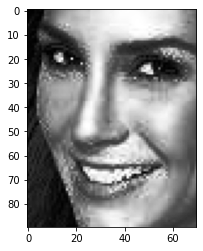

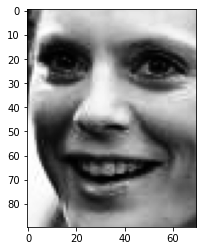

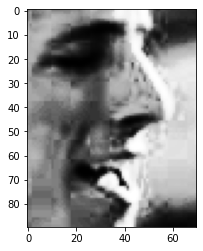

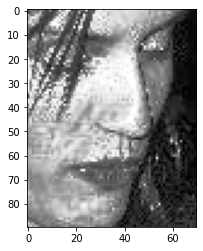

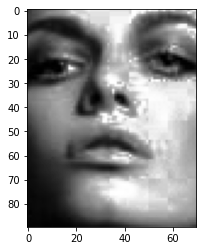

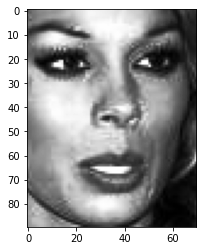

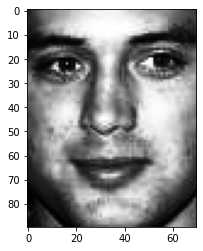

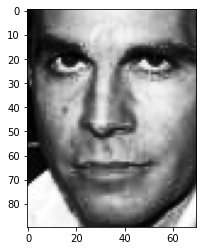

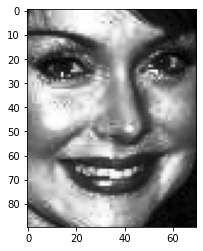

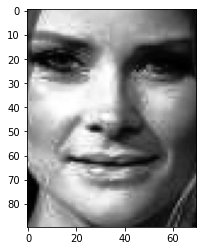

In [7]:
for i in range(10):
    plt.imshow(X[i], cmap='gray')
    plt.show()

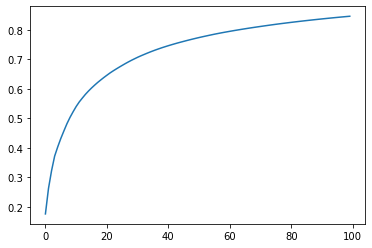

In [8]:
X_extract = model.feature_extraction(X)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_extract, y, test_size=0.1)

In [10]:
print(model.fit(X_extract, y))

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 555
max_resources_: 5000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 555
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END C=0.5, gamma=0.005;, score=(train=0.957, test=0.838) total time=   0.0s
[CV 2/5] END C=0.5, gamma=0.005;, score=(train=0.919, test=0.784) total time=   0.0s
[CV 3/5] END C=0.5, gamma=0.005;, score=(train=0.968, test=0.838) total time=   0.0s
[CV 4/5] END C=0.5, gamma=0.005;, score=(train=0.946, test=0.766) total time=   0.0s
[CV 5/5] END C=0.5, gamma=0.005;, score=(train=0.975, test=0.874) total time=   0.0s
[CV 1/5] END C=0.5, gamma=0.01;, score=(train=0.991, test=0.793) total time=   0.0s
[CV 2/5] END C=0.5, gamma=0.01;, score=(train=0.887, test=0.631) total time=   0.0s
[CV 3/5] END C=0.5, gamma=0.01;, score=(train=0.995, test=0.586) total time=   0.0s
[CV 4/5] END C=0.5, gamma=0.01;, score=(train=0.977, test=0.6

[CV 4/5] END C=5, gamma=0.1;, score=(train=1.000, test=0.495) total time=   0.0s
[CV 5/5] END C=5, gamma=0.1;, score=(train=1.000, test=0.532) total time=   0.0s
[CV 1/5] END C=10, gamma=0.005;, score=(train=1.000, test=0.883) total time=   0.0s
[CV 2/5] END C=10, gamma=0.005;, score=(train=1.000, test=0.874) total time=   0.0s
[CV 3/5] END C=10, gamma=0.005;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/5] END C=10, gamma=0.005;, score=(train=1.000, test=0.829) total time=   0.0s
[CV 5/5] END C=10, gamma=0.005;, score=(train=1.000, test=0.874) total time=   0.0s
[CV 1/5] END C=10, gamma=0.01;, score=(train=1.000, test=0.793) total time=   0.0s
[CV 2/5] END C=10, gamma=0.01;, score=(train=1.000, test=0.766) total time=   0.0s
[CV 3/5] END C=10, gamma=0.01;, score=(train=1.000, test=0.865) total time=   0.0s
[CV 4/5] END C=10, gamma=0.01;, score=(train=1.000, test=0.793) total time=   0.0s
[CV 5/5] END C=10, gamma=0.01;, score=(train=1.000, test=0.856) total time=   0.0s
[CV

In [11]:
X_test, y_test = load_data(dataset+TEST, feature_col, file_col, model.load_image)

celeba_test:   0%|          | 0/1000 [00:00<?, ?it/s]

Loaded 50,400,000 bytes


In [12]:
y_pred = model.predict(model.feature_extraction(X_test, test=True))

In [13]:
print(accuracy_score(y_test,y_pred))

0.931
